In [1]:
# Importing key libraries 
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults 
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse,mse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [3]:
# Load dataset
df = pd.read_excel('PublicExpanditureOnPensions.xlsx',index_col='Year',parse_dates=True)

In [4]:
df.head()

,PE,Old_Age_Pensions_Expenditure
Year,,
1995-01-01,1090.91,775.95
1996-01-01,1201.45,862.67
1997-01-01,1365.67,983.00
1998-01-01,1472.27,1066.94
1999-01-01,1437.06,1040.42


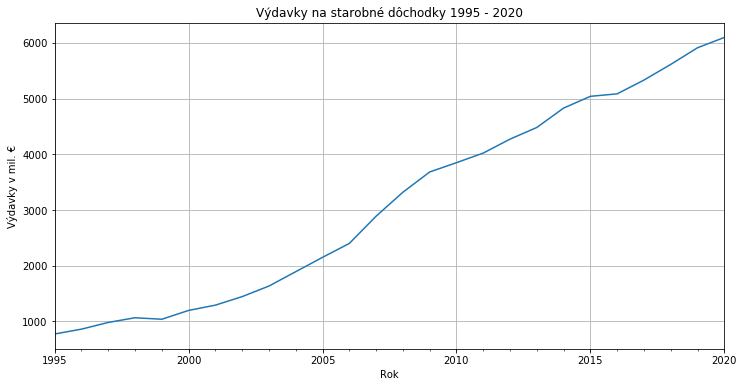

In [7]:
#Data Plot
title = 'Výdavky na starobné dôchodky 1995 - 2020'
xlabel = 'Rok'
ylabel = 'Výdavky v mil. €'

ax = df['Old_Age_Pensions_Expenditure'].plot(figsize=(12,6),title=title,grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

In [8]:
#ACF calculation
acf(df['Old_Age_Pensions_Expenditure'])

array([ 1.        ,  0.90336679,  0.80004296,  0.69672984,  0.59265029,
        0.48371701,  0.36773348,  0.24995521,  0.13809491,  0.02970348,
       -0.07122103, -0.16782522, -0.26013434, -0.33273647, -0.38307485,
       -0.40982287, -0.42647345, -0.43185631, -0.42343529, -0.40400015,
       -0.37028139, -0.32802887, -0.27967029, -0.22612738, -0.16205548,
       -0.08525058])

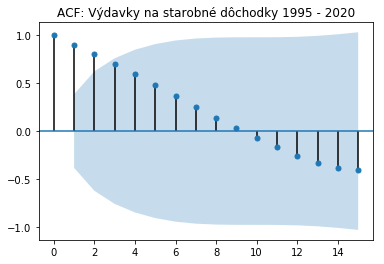

In [10]:
#ACF plot
title = 'ACF: Výdavky na starobné dôchodky 1995 - 2020'
lags = 15
plot_acf(df['Old_Age_Pensions_Expenditure'],title=title,lags=lags);

In [14]:
#PACF calculation
pacf(df['Old_Age_Pensions_Expenditure'])

array([ 1.        ,  0.93950146, -0.13593148, -0.08378059, -0.10612195,
       -0.16498565, -0.21800746, -0.2056293 , -0.16209013, -0.24365653,
       -0.25139055, -0.41447986, -0.73922925, -1.98392885,  1.93754523,
        0.70554998,  0.27357991,  0.22361776,  0.19197949,  0.06353264,
        0.21098639,  0.02393831, -0.08055713, -0.29323924, -0.03196391,
        0.47628868,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])

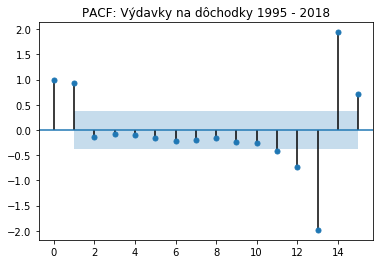

In [15]:
#PACF plot
title = 'PACF: Výdavky na starobné dôchodky 1995 - 2020'
lags = 15
plot_pacf(df['Old_Age_Pensions_Expenditure'],title=title,lags=lags);

In [16]:
adf_test(df['Old_Age_Pensions_Expenditure'])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.606235
p-value                  0.997876
# lags used              0.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


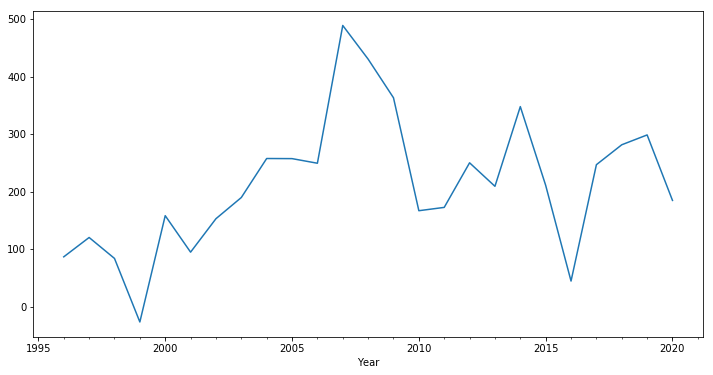

In [17]:
#Differencing data due to non stationarity - 1st difference
df['d1'] = diff(df['Old_Age_Pensions_Expenditure'],k_diff=1)
df['d1'].plot(figsize=(12,6));

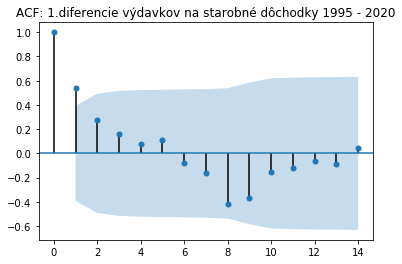

In [19]:
#ACF plot for 1st difference
title='ACF: 1.diferencie výdavkov na starobné dôchodky 1995 - 2020'
lags=15
plot_acf(df['d1'].dropna(),title=title,lags=np.arange(lags));

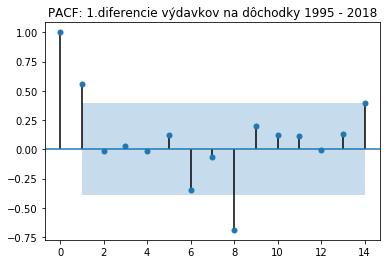

In [20]:
#PACF plot for 1st difference
title='PACF: 1.diferencie výdavkov na dôchodky 1995 - 2018'
lags=15
plot_pacf(df['d1'].dropna(),title=title,lags=np.arange(lags));

In [21]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.147095
p-value                  0.023259
# lags used              7.000000
# observations          17.000000
critical value (1%)     -3.889266
critical value (5%)     -3.054358
critical value (10%)    -2.666984
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


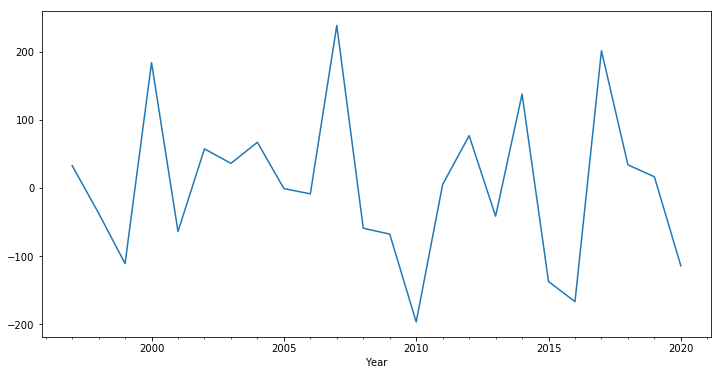

In [22]:
#Differencing data due to non stationarity - 2nd difference
df['d2'] = diff(df['Old_Age_Pensions_Expenditure'],k_diff=2)
df['d2'].plot(figsize=(12,6));

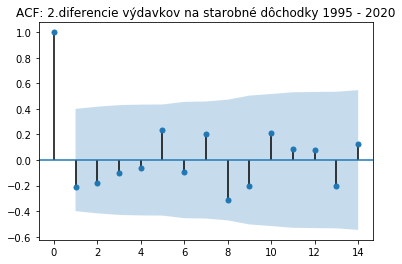

In [23]:
#ACF plot for 2nd difference
title='ACF: 2.diferencie výdavkov na starobné dôchodky 1995 - 2020'
lags=15
plot_acf(df['d2'].dropna(),title=title,lags=np.arange(lags));

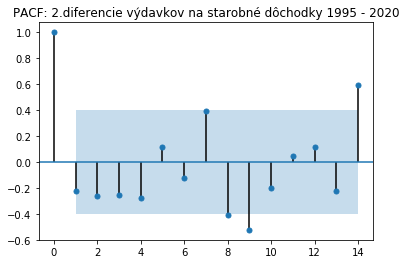

In [24]:
#PACF plot for 2nd difference
title='PACF: 2.diferencie výdavkov na starobné dôchodky 1995 - 2020'
lags=15
plot_pacf(df['d2'].dropna(),title=title,lags=np.arange(lags));

In [25]:
adf_test(df['d2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.588816
p-value                  0.000001
# lags used              0.000000
# observations          23.000000
critical value (1%)     -3.752928
critical value (5%)     -2.998500
critical value (10%)    -2.638967
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [26]:
#Running auto_arima function which measures many different models, do the differencing on its own

stepwise_fit = auto_arima(df['Old_Age_Pensions_Expenditure'], start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          seasonal=False,
                          d=1,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=307.913, BIC=312.789, Fit time=0.105 seconds
Fit ARIMA: order=(0, 1, 0); AIC=312.632, BIC=315.070, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0); AIC=305.919, BIC=309.576, Fit time=0.047 seconds
Fit ARIMA: order=(0, 1, 1); AIC=307.365, BIC=311.022, Fit time=0.031 seconds
Fit ARIMA: order=(2, 1, 0); AIC=307.914, BIC=312.790, Fit time=0.085 seconds
Fit ARIMA: order=(2, 1, 1); AIC=308.543, BIC=314.637, Fit time=0.124 seconds
Total fit time: 0.395 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   25
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -149.960
Method:                       css-mle   S.D. of innovations             96.779
Date:                Wed, 09 Mar 2022   AIC                            305.919
Time:                        10:03:23   BIC                            309.576
Sample:                             1   HQIC                           306.934
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        206.1257     40.766      5.056      0.000     126.226     286.025
ar.L1.D.y      0.5441      0.165      3.295      0.003       0.220       0.868
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8380           +0.0000j            1.8380            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
# Splitting into train and test period
train = df.iloc[:19]
test = df.iloc[19:]

In [30]:
#Checking the best model after splitting

model = ARIMA(train['Old_Age_Pensions_Expenditure'],order=(1,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   ARIMA Model Results                                    
==========================================================================================
Dep. Variable:     D.Old_Age_Pensions_Expenditure   No. Observations:                   18
Model:                             ARIMA(1, 1, 0)   Log Likelihood                -107.042
Method:                                   css-mle   S.D. of innovations             91.106
Date:                            Wed, 09 Mar 2022   AIC                            220.083
Time:                                    10:04:13   BIC                            222.754
Sample:                                01-01-1996   HQIC                           220.451
                                     - 01-01-2013                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  195.6768     57.395      3.409      0.004      83.184     308.170
ar.L1.D.Old_Age_Pensions_Expenditure     0.6584      0.167      3.940      0.001       0.331       0.986
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5188           +0.0000j            1.5188            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,0) Test predictions')

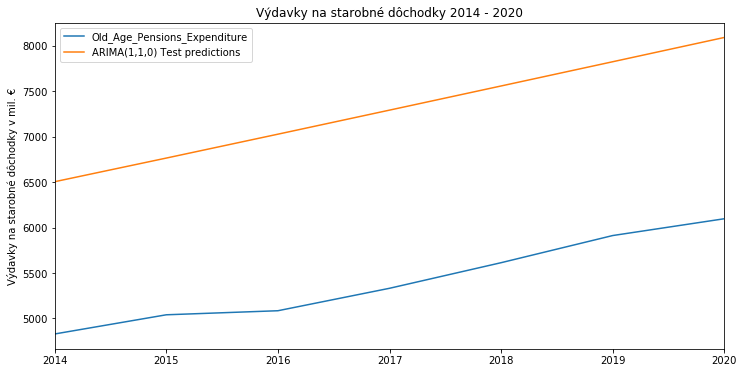

In [33]:
#Plotting predictions vs. expected data
title = 'Výdavky na starobné dôchodky 2014 - 2020'
ylabel='Výdavky na starobné dôchodky v mil. €'
xlabel='' # we don't really need a label here

ax = test['Old_Age_Pensions_Expenditure'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [32]:
# predicted vs. expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Old_Age_Pensions_Expenditure'][i]}")

predicted=6504.473381, expected=4829.79
predicted=6764.38703 , expected=5040.78
predicted=7027.078189, expected=5085.38
predicted=7291.588703, expected=5332.23
predicted=7557.290954, expected=5613.72
predicted=7823.773828, expected=5912.3
predicted=8090.768036, expected=6097.06


In [34]:
#MSE and RMSE calculation
error = mse(test['Old_Age_Pensions_Expenditure'], predictions)
print(f'ARIMA(1,1,0) MSE Error: {error:11.10}')
error = rmse(test['Old_Age_Pensions_Expenditure'], predictions)
print(f'ARIMA(1,1,0) RMSE Error: {error:11.10}')

ARIMA(1,1,0) MSE Error: 3541533.712
ARIMA(1,1,0) RMSE Error: 1881.896307


In [35]:
#Retraining the model on full dataset
model = ARIMA(df['Old_Age_Pensions_Expenditure'],order=(1,1,0))
results = model.fit()
forecast = results.predict(len(df),len(df)+9,typ='levels').rename('ARIMA(1,1,0) Forecast')

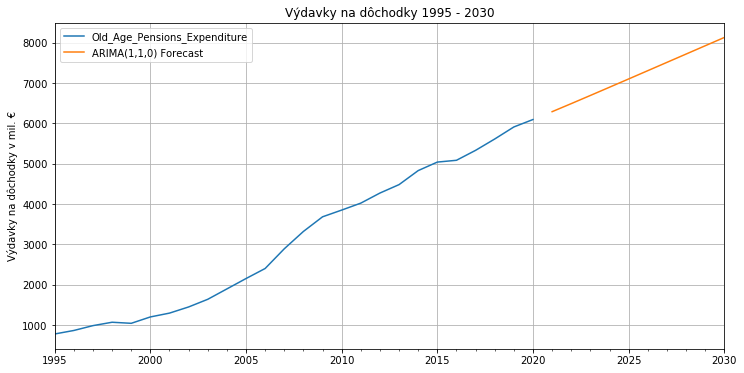

In [36]:
# Plot predictions against known values
title = 'Výdavky na dôchodky 1995 - 2030'
ylabel='Výdavky na dôchodky v mil. €'
xlabel='' # we don't really need a label here

ax = df['Old_Age_Pensions_Expenditure'].plot(legend=True,figsize=(12,6),title=title, grid=True)
forecast.plot(legend=True,grid=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [37]:
forecast

2021-01-01    6291.561461
2022-01-01    6491.362866
2023-01-01    6694.047762
2024-01-01    6898.301451
2025-01-01    7103.408658
2026-01-01    7308.980231
2027-01-01    7514.804447
2028-01-01    7720.766116
2029-01-01    7926.802568
2030-01-01    8132.879706
Freq: AS-JAN, Name: ARIMA(1,1,0) Forecast, dtype: float64

,PE,d1,d2
Year,,,
2016-01-01,6884.48,91.40,-93.94
2017-01-01,7182.59,298.11,206.71
2018-01-01,7511.99,329.40,31.29
2019-01-01,7810.33,298.34,-31.06
2020-01-01,7758.51,-51.82,-350.16


In [38]:
model = ARIMA(train['Old_Age_Pensions_Expenditure'],order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   ARIMA Model Results                                    
==========================================================================================
Dep. Variable:     D.Old_Age_Pensions_Expenditure   No. Observations:                   18
Model:                             ARIMA(0, 1, 1)   Log Likelihood                -108.754
Method:                                   css-mle   S.D. of innovations            100.832
Date:                            Wed, 09 Mar 2022   AIC                            223.509
Time:                                    10:06:57   BIC                            226.180
Sample:                                01-01-1996   HQIC                           223.877
                                     - 01-01-2013                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  203.3927     35.874      5.670      0.000     133.081     273.704
ma.L1.D.Old_Age_Pensions_Expenditure     0.5385      0.181      2.967      0.009       0.183       0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.8570           +0.0000j            1.8570            0.5000
-----------------------------------------------------------------------------
"""

In [39]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,1) Test predictions')

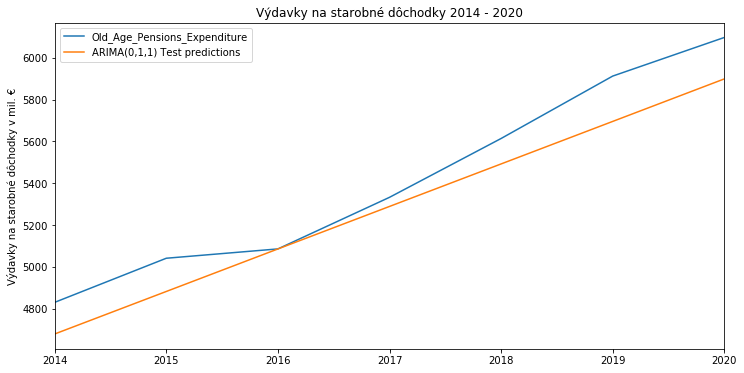

In [40]:
#Plotting predictions vs. expected data
title = 'Výdavky na starobné dôchodky 2014 - 2020'
ylabel='Výdavky na starobné dôchodky v mil. €'
xlabel='' # we don't really need a label here

ax = test['Old_Age_Pensions_Expenditure'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [41]:
# predicted vs. expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Old_Age_Pensions_Expenditure'][i]}")

predicted=4678.431304, expected=4829.79
predicted=4881.823992, expected=5040.78
predicted=5085.21668 , expected=5085.38
predicted=5288.609369, expected=5332.23
predicted=5492.002057, expected=5613.72
predicted=5695.394745, expected=5912.3
predicted=5898.787433, expected=6097.06


In [42]:
#MSE and RMSE calculation
error = mse(test['Old_Age_Pensions_Expenditure'], predictions)
print(f'ARIMA(1,1,0) MSE Error: {error:11.10}')
error = rmse(test['Old_Age_Pensions_Expenditure'], predictions)
print(f'ARIMA(1,1,0) RMSE Error: {error:11.10}')

ARIMA(1,1,0) MSE Error:  21607.7731
ARIMA(1,1,0) RMSE Error: 146.9958268


In [43]:
#Retraining the model on full dataset
model = ARIMA(df['Old_Age_Pensions_Expenditure'],order=(0,1,1))
results = model.fit()
forecast = results.predict(len(df),len(df)+9,typ='levels').rename('ARIMA(0,1,1) Forecast')

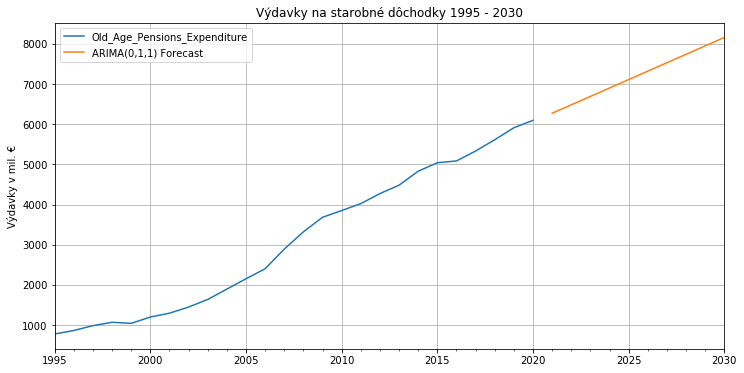

In [46]:
# Plot predictions against known values
title = 'Výdavky na starobné dôchodky 1995 - 2030'
ylabel='Výdavky v mil. €'
xlabel='' # we don't really need a label here

ax = df['Old_Age_Pensions_Expenditure'].plot(legend=True,figsize=(12,6),title=title, grid=True)
forecast.plot(legend=True,grid=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [45]:
forecast

2021-01-01    6272.442613
2022-01-01    6482.291288
2023-01-01    6692.139964
2024-01-01    6901.988639
2025-01-01    7111.837315
2026-01-01    7321.685990
2027-01-01    7531.534666
2028-01-01    7741.383342
2029-01-01    7951.232017
2030-01-01    8161.080693
Freq: AS-JAN, Name: ARIMA(0,1,1) Forecast, dtype: float64

In [47]:
df.tail()

,PE,Old_Age_Pensions_Expenditure,d1,d2
Year,,,,
2016-01-01,6884.48,5085.38,44.60,-166.39
2017-01-01,7182.59,5332.23,246.85,202.25
2018-01-01,7511.99,5613.72,281.49,34.64
2019-01-01,7810.33,5912.30,298.58,17.09
2020-01-01,7758.51,6097.06,184.76,-113.82
